In [1]:
! pip install pytorch-metric-learning

In [5]:
import timm
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from cycler import cycler
from torch import optim
import os

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.reducers import ThresholdReducer

In [6]:
class CFG:
    data_path = "./dataset/" 
    model_name = ["vgg16","efficientnet_b0","resnet34d"]
    epoch = 10
    pretrained = True
    inp_channels = 1
    batch_size = 64
    lr = 1e-5
    out_features = 10
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

In [8]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = datasets.FashionMNIST(CFG.data_path, train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(CFG.data_path, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [9]:
class CustomModel(nn.Module):
    def __init__(
        self, model_name=CFG.model_name, n_class=CFG.out_features, pretrained=CFG.pretrained, in_chans=CFG.inp_channels):
        super().__init__()
        self.backbone = timm.create_model(
            model_name, pretrained=pretrained, num_classes = n_class, in_chans=in_chans)
      
    def forward(self, x):
        x = self.backbone(x)
        output = x
        return output

In [10]:
def train(model, loss_func, mining_func, device, dataloader, optimizer, epoch):
    model.train() 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print('Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}'.format(epoch, idx, loss, mining_func.num_triplets))

In [20]:
def test(model, dataloader, device, epoch):
    _predicted_metrics = []
    _true_labels = []
    with torch.no_grad():    
        for i, (inputs,  labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            _predicted_metrics.append(metric)
            _true_labels.append(labels.detach().cpu().numpy())
    return np.concatenate(_predicted_metrics), np.concatenate(_true_labels)

In [12]:
if __name__ == '__main__':
    
    model = CustomModel(model_name=CFG.model_name[2]).to(CFG.device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
    
    test_predicted_metrics = []
    test_true_labels = []
    model_loss = 0
    best_model_loss = 100


    distance = CosineSimilarity()
    reducer = ThresholdReducer(low = 0)
    losser = TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    miner = TripletMarginMiner(margin=0.2, distance=distance)
    
    loss_func = losser
    mining_func = miner
    
    for epoch in range(1, CFG.epoch + 1):
        print('Epoch {}/{}'.format(epoch, CFG.epoch))
        print('-' * 10)
        train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
        if epoch % 5 == 0 or epoch ==1:
            torch.save(model.state_dict(),f'epoch{epoch}_model.pth')

Epoch 1/10
----------
Epoch 1 Iteration 0: Loss = 0.41610944271087646, Number of mined triplets = 15323
Epoch 1 Iteration 100: Loss = 0.4124983251094818, Number of mined triplets = 14225
Epoch 1 Iteration 200: Loss = 0.36883997917175293, Number of mined triplets = 14378
Epoch 1 Iteration 300: Loss = 0.38162490725517273, Number of mined triplets = 14424
Epoch 1 Iteration 400: Loss = 0.3920902609825134, Number of mined triplets = 14753
Epoch 1 Iteration 500: Loss = 0.34644296765327454, Number of mined triplets = 13154
Epoch 1 Iteration 600: Loss = 0.37233754992485046, Number of mined triplets = 11497
Epoch 1 Iteration 700: Loss = 0.33931249380111694, Number of mined triplets = 11087
Epoch 1 Iteration 800: Loss = 0.30875539779663086, Number of mined triplets = 8966
Epoch 1 Iteration 900: Loss = 0.31887784600257874, Number of mined triplets = 10277
Epoch 2/10
----------
Epoch 2 Iteration 0: Loss = 0.29111650586128235, Number of mined triplets = 9514
Epoch 2 Iteration 100: Loss = 0.27500501

Epoch 10 Iteration 700: Loss = 0.20011882483959198, Number of mined triplets = 1525
Epoch 10 Iteration 800: Loss = 0.1678042709827423, Number of mined triplets = 1148
Epoch 10 Iteration 900: Loss = 0.2007482945919037, Number of mined triplets = 2027


In [23]:
inf_model = CustomModel(model_name=CFG.model_name[2]).to(CFG.device)
inf_model.load_state_dict(torch.load('epoch10_model.pth'))
test_predicted_metrics, test_true_labels = test(inf_model, test_loader, CFG.device, epoch)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


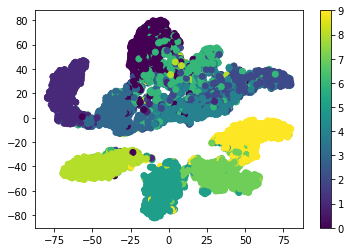

In [24]:
tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(test_predicted_metrics)

plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
plt.colorbar()
plt.savefig("output.png")
plt.show()